# Network measurement laboratory - report 5


## Introduction
The goal of this lab is to implement a machine learning pipeline to determine to which service class each TCP connection recorded in the provided Tstat dataframe belongs. In each task we will perform one step of the typical machine learning workflow to analyze the results in detail, comment on them and add some theoretical notes

In [46]:
# import general libraries, more will be added later
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import pandas as pd
import time

# Part 1: Classification Problem

## Task 1: data inspection

N. flows =  100000
N. classes =  10
['class:google' 'class:bing' 'class:linkedin' 'class:instagram'
 'class:youtube' 'class:netflix' 'class:spotify' 'class:facebook'
 'class:ebay' 'class:amazon']


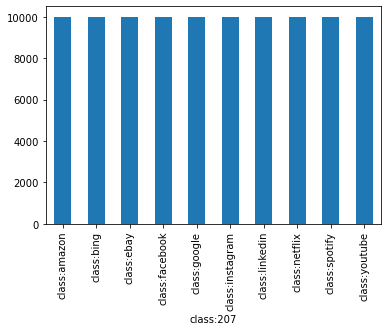

In [3]:
df = pd.read_csv('log_tcp_complete_classes.txt', sep = " ")
n_flows = df.shape[0]
classes = df['class:207'].unique()
n_classes = len(classes)

print("N. flows = ", n_flows)
print("N. classes = ", n_classes)
print(classes)

a = df.groupby(['class:207']).size().sort_values(ascending=False).plot(kind='bar')

By performing some basic inspection of the data we can see that it consists of 10^5 connections evenly split among 10 connection classes, which correspond to some very popular web services. What can be guessed at a first glance is that some of these classes, like netflix and youtube or instagram and facebook, have similar traffic patterns and are not easily distinguishable. Looking at the Tstat documentation, the most obvious columns to look at would be the server IP, server port and DNS name. However, since those would make the problem trivial, we can look at other columns that could prove useful: 

- connection type (column 42) : it can be useful since some services may use protocols different from TLS
- HTTP type (column 44): since we do not know from which year the data is, it could very well be old enough that HTTP was still in use and in that case this column could help 
- data bytes exchanged (columns 9 and 23): can help differentiate services that exchange large amounts of data (e.g. YouTube) from those that don't (e.g. Bing)
- flow duration (column 31): like column 9/23 but less reliable, since it also depends on traffic conditions and server load
- average RTT (column 45): could be useful to determine the distance of the server to be contacted, but depends on server load and could be prone to overfitting if not treated carefully: since data is most likely taken from a single location all the RTT for a specific server of a specific service will be very similar 
- columns 132 to 192: these columns add a lot of information about the exchanged packets and can be mapped to service specific protocols

## Task 2: data cleaning

In [4]:
to_drop = [
    "#31#c_ip:1", 
    "c_port:2", 
    "s_ip:15", 
    "s_port:16", 
    "c_tls_SNI:116", 
    "s_tls_SCN:117", 
    "fqdn:127"]

df = df.drop(to_drop, axis=1)

cat_features = [
'con_t:42',
'p2p_t:43',
'http_t:44',
'p2p_st:59',
'c_npnalpn:118',
's_npnalpn:119',
'dns_rslv:128',
"http_res:113",
]

In this step we remove from the dataframe all the columns that we won't need later, since they would either make the problem trivial or are categorical features of high cardinality. During initial testing we removed most of the columns except for a select few in order to speed up computation, which obviously resulted in a much lower accuracy. We also prepare a list of which features are categorical, since we will need it later on.  

## Task 3: data splitting

In [5]:
x_train, x_test, y_train, y_test \
    = train_test_split(df.drop('class:207', axis=1), \
                       df['class:207'], test_size=0.3, random_state=0)

print("Training test size: ", len(x_train), "\nTest set size: ", len(x_test))

Training test size:  70000 
Test set size:  30000


The cleaned dataset is then split into training and testing sets. The training set is the one we will feed to the fit methods of the classifier, while the testing set is the one on which we will validate the results obtained up to that point. The training set is obviously the most important one and therefore most of the original dataframe ends up there, with the most common ratios being 80:20 and 70:30. One important thing to remember is to randomize the data when performing the split, since we could otherwise end up with unbalanced datasets that favor overfitting.

## Task 4: data preprocessing

In [6]:
# define preprocessers
oh_enc = OneHotEncoder(handle_unknown='ignore')
ss_enc = StandardScaler()

# preprocess the categorical features
x_train_prep_cat = pd.DataFrame(oh_enc.fit_transform(x_train[cat_features]).toarray(), \
                                columns = oh_enc.get_feature_names())
            
# remove old categorical features
x_train_sc_only = x_train.drop(cat_features, axis=1)

x_train = pd.DataFrame(ss_enc.fit_transform(x_train_sc_only), columns = x_train_sc_only.columns)\
                        .join(x_train_prep_cat.reset_index(drop=True))

,c_pkts_all:3,c_rst_cnt:4,c_ack_cnt:5,c_ack_cnt_p:6,c_bytes_uniq:7,c_pkts_data:8,c_bytes_all:9,c_pkts_retx:10,c_bytes_retx:11,c_pkts_ooo:12,...,x7_206,x7_301,x7_302,x7_304,x7_400,x7_403,x7_404,x7_405,x7_410,x7_500
0,-0.031335,-0.607899,-0.031257,-0.076164,-0.006302,-0.007566,-0.005167,0.053891,0.076924,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.036628,-0.607899,-0.036550,-0.084666,-0.008318,-0.010360,-0.008446,-0.033697,-0.014256,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.035040,-0.607899,-0.034962,-0.082965,-0.008455,-0.009801,-0.008583,-0.033697,-0.014256,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.035570,1.645010,-0.036021,-0.084666,-0.008100,-0.010360,-0.008230,-0.033697,-0.014256,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.038746,-0.607899,-0.038668,-0.089766,-0.008811,-0.011478,-0.008936,-0.033697,-0.014256,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,-0.030806,-0.607899,-0.032845,-0.079565,-0.008454,-0.008684,-0.008581,0.141480,-0.014116,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69996,-0.039275,-0.607899,-0.039197,-0.091467,-0.008831,-0.011478,-0.008955,-0.033697,-0.014256,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69997,-0.033452,-0.607899,-0.033374,-0.084666,-0.007808,-0.008125,-0.007941,0.010097,-0.014221,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69998,-0.039275,-0.607899,-0.039197,-0.091467,-0.008831,-0.011478,-0.008955,-0.033697,-0.014256,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


During the preprocessing phase we need to differentiate between categorical and scalar features (binary features can be considered categorical for this purpose) since they need to be treated differently. Scalar features need to be normalized through the StandardScaler estimator, that simply centers the data by removing the mean value of each feature and dividing the result by their standard deviation: this is done to avoid problems that can arise due to large variance in the data, and is especially relevant when training neural networks. In our specific case some features have noticeable variance, but our algorithms of choice do not strictly require data scaling (as we will see more in detail later). Categorical features are more problematic, since they don't consist of meaningful continuous numerical data, and must therefore be mapped to integer values. To do this we can use either an ordinal encoder, which maps each feature to an integer in (0, n_categories) but would require further processing, or a OneHotEncoder, which converts each feature into n_categories binary features. This last one is the solution we adopted, but we need to specify how the encoder will behave in case an unknown feature is found in the testing set.

## Task 5: train algorithm
Now we need to use the processed data to train two machine learning algorithms of our choice: in our case the decision tree and random forest algorithms have been chosen, since their several similarities allow direct comparison of advantages and disadvantages. 

### 5.1: Decision Tree
The decision tree is the simplest machine learning algorithm and consists of a series of decisions based on conditional control statements. It is relatively inexpensive to construct and fast at classifying unknown records without loosing to much in terms of accuracy. Another advantage of decision trees is that the control statements are made on one feature at a time, so data variance does not impact the algorithm's output and we can avoid applying a standard scaler to the dataset.

In [7]:
from sklearn.tree import DecisionTreeClassifier

tree_c = DecisionTreeClassifier()

t_start = time.time()
tree_c.fit(x_train, y_train)
y_pred_tree = tree_c.predict(x_train)
tree_time = time.time() - t_start

### 5.2: Random Forest
A random forest is a classifier that consists of several decision trees, which are constructed with only a subset of features, that classify the data and then output the final decision through majority vote. It has a lot of the advantages of decision trees (like not requiring data scaling), but is also one of the most accurate algorithms, especially on large databases, and can be used to understand which features are more relevant in the classification. 

In [8]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=0)

t_start = time.time()
rfc.fit(x_train, y_train)
y_pred_rfc = rfc.predict(x_train)
rfc_time = time.time() - t_start

## Task 6: performance evaluation

In this section we evaluate the performance of the chosen algorithms. The accuracy score is the most basic metric available, but is also the least significant as it can provide misleading information (like in the textbook example of a classifier that always chooses one class). This happens because when evaluating different settings (“hyperparameters”) for estimators there is still a risk of overfitting on the test set, since the parameters can be tweaked until the estimator performs optimally. This way, knowledge about the test set can “leak” into the model and evaluation metrics no longer report on generalization performance. To solve this problem, yet another part of the dataset can be held out as a so-called “validation set”: training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the test set. However, by partitioning the available data into three sets, we drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets.

A solution to this problem is a procedure called cross-validation (CV for short). A test set should still be held out for final evaluation, but the validation set is no longer needed. In the k-fold CV approach the training set is split into k smaller sets, or folds: for each fold, the model is trained using k-1 sets and then is validated on the remaining part of the data. The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop. This approach can be computationally expensive, but does not waste too much data (as is the case when fixing an arbitrary validation set), which is a major advantage in problems where the number of samples is very small.

### 6.1: Decision Tree

Decision tree classifier:
-global accuracy score ->  0.9995285714285714 
-time ->  7.184864521026611
Average cross validation score 3-fold:  0.9853571682473256
Average cross validation score 5-fold:  0.9866316807068959


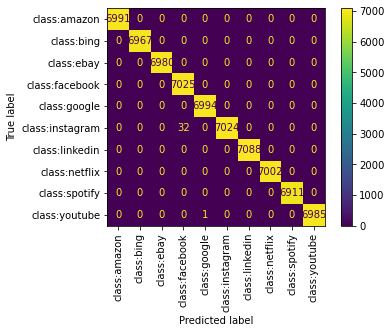

In [8]:
# metrics
print("Decision tree classifier:\n-global accuracy score -> ", accuracy_score(y_pred_tree, y_train),\
      "\n-time -> ", tree_time)
cv_3_avg = cross_val_score(tree_c, x_train, y_train, scoring='f1_macro', cv=3).mean()
cv_5_avg = cross_val_score(tree_c, x_train, y_train, scoring='f1_macro', cv=5).mean()
print("Average cross validation score 3-fold: ", cv_3_avg)
print("Average cross validation score 5-fold: ", cv_5_avg)

# confusion matrix
tree_cm = confusion_matrix(y_train, y_pred_tree, labels=tree_c.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=tree_cm, display_labels=tree_c.classes_)\
        .plot(xticks_rotation='vertical')

The accuracy of the decision tree on the training set is very high, as validated by both the 3 and 5 fold cross validation scores. From the confusion matrix we can see that most of the errors are due to confusion between the pair Instagram-Facebook, which is understandable as these two services are very similar in content and purpose (non to mention that some of their servers are shared). The training and prediction time is not negligible, but that is to be expected seeing the relatively large amount of data.

### 6.2: Random Forest

Random forest classifier:
-global accuracy score ->  0.9995285714285714 
-time ->  26.65215301513672
Average cross validation score 3-fold:  0.9913096712070318
Average cross validation score 5-fold:  0.9919798921078895

Error scaling factor with respect to decision tree:  0.5999338971689262


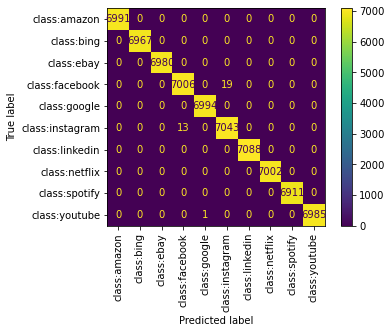

In [10]:
# metrics
print("Random forest classifier:\n-global accuracy score -> ", accuracy_score(y_pred_rfc, y_train),\
      "\n-time -> ", rfc_time)

cv_3_avg_rfc = cross_val_score(rfc, x_train, y_train, scoring='f1_macro', cv=3).mean()
cv_5_avg_rfc = cross_val_score(rfc, x_train, y_train, scoring='f1_macro', cv=5).mean()
print("Average cross validation score 3-fold: ", cv_3_avg_rfc)
print("Average cross validation score 5-fold: ", cv_5_avg_rfc)

improvement = (1-cv_5_avg_rfc)/(1-cv_5_avg)
print("\nError scaling factor with respect to decision tree: ", improvement)
# confusion matrix
rfc_cm = confusion_matrix(y_train, y_pred_rfc, labels=rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=rfc_cm, display_labels=rfc.classes_)\
        .plot(xticks_rotation='vertical')

As expected training and prediction time is several times higher than for the simple decision tree, since we have to take into account not only the time to build the individual trees but also the time to try different splits. Looking at the accuracy from the accuracy score and confusion matrix there does not appear to have been any improvement as the absolute number of errors (which are still due to the Instagram-Facebook pair) is the same, but by comparing the 5-fold cross validation score we can see that the error is now only 60% of the one we had with the decision tree. This is proof that the cross validation scoring method is more reliable and is worth the extra time.

## Task 7: parameter tuning
We chose the random forest as classifier to perform the grid search on, even though this choice makes the search process very long, because it has more parameters that are interesting to explore. These are the two parameters we chose:
- *n_estimators* specifies the number of trees in the forest and assumes the value 100 by default. We expect the performance to improve as it increases and to test this hypothesis we will perform the grid search for values 50, 100 and 200.
- *max_features* specifies the maximum number of features to consider when performing a new split during the training procedure. It is set by default to sqrt, meaning that only sqrt(n_features) are considered. 

In [9]:
# candidates: n_estimators, max_samples
param_grid = {'n_estimators':[50, 100, 200], 'max_features':[None, 'sqrt', 'log2']}

t_start = time.time()
grid = GridSearchCV(RandomForestClassifier(random_state=0), param_grid, scoring='f1_macro', cv=3, n_jobs=4)
grid.fit(x_train, y_train)
grid_time = time.time() - t_start

grid_results_df = pd.DataFrame().from_dict(grid.cv_results_)
best_estimator = grid.best_estimator_

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,121.731463,1.406125,0.322989,0.017994,None,50,"{'max_features': None, 'n_estimators': 50}",0.990969,0.990670,0.989169,0.990269,0.000787,6
1,239.745012,4.504950,0.480024,0.002986,None,100,"{'max_features': None, 'n_estimators': 100}",0.991227,0.991011,0.989424,0.990554,0.000804,4
2,495.667466,10.586445,0.976794,0.098302,None,200,"{'max_features': None, 'n_estimators': 200}",0.991098,0.990539,0.989767,0.990468,0.000546,5
3,8.119963,0.088427,0.389255,0.007767,sqrt,50,"{'max_features': 'sqrt', 'n_estimators': 50}",0.991052,0.991267,0.990496,0.990938,0.000325,3
4,16.007502,0.128214,0.650640,0.007120,sqrt,100,"{'max_features': 'sqrt', 'n_estimators': 100}",0.991693,0.991611,0.990625,0.991310,0.000485,2
5,31.929012,0.162825,1.185857,0.013830,sqrt,200,"{'max_features': 'sqrt', 'n_estimators': 200}",0.991607,0.991269,0.991180,0.991352,0.000184,1
6,4.663775,0.029394,0.433733,0.003859,log2,50,"{'max_features': 'log2', 'n_estimators': 50}",0.989033,0.988483,0.987884,0.988467,0.000469,9
7,9.166559,0.045022,0.751298,0.005234,log2,100,"{'max_features': 'log2', 'n_estimators': 100}",0.989848,0.989213,0.988869,0.989310,0.000405,8
8,18.422409,0.027740,1.385714,0.016353,log2,200,"{'max_features': 'log2', 'n_estimators': 200}",0.989892,0.989854,0.988826,0.989524,0.000494,7


Total search time was 48 minutes


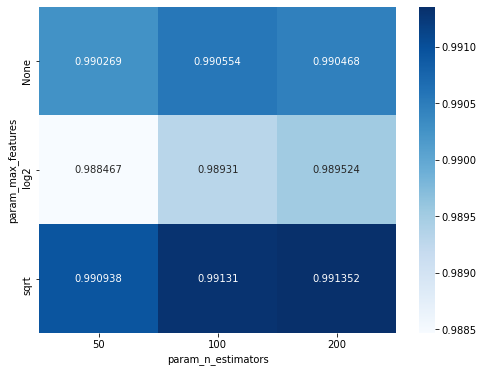

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

print("Total search time was", round(grid_time/60), "minutes")

grid_results_df.fillna('All features', inplace=True)
table = pd.pivot_table(grid_results_df,\
                       values='mean_test_score', index='param_max_features', columns='param_n_estimators',\
                      fill_value=0)

plt.figure(figsize=(8,6))
a = sns.heatmap(table, annot=True, cmap='Blues', fmt='g')

The heatmap shows the results of our grid search. As expected increasing the number of estimators always improves performance, while interestingly the same can't be said about the number of features included in each split. Using *log2* yielded the worst performance, while the best one was obtained with the default parameter sqrt. Overall the best combination of parameters was *max_features='sqrt'* and *n_estimators=200*. 

As espected the grid search took a very long time to perform even if the parameter *n_jobs* was increased to 4 from the default 1, since it had to perform threefold cross validation of a random forest (which takes a long time, as seen during task 6) for each combination of parameters. This was a long but acceptable time in our case but performance does not scale well with the search space.

There are a few ways to improve the search speed, but they all have their advantages and disadvantages:
- we could further increase the number of jobs, but this is limited by the hardware performing the computation
- we could use a simpler and faster classification algorithm, but we would loose on the performance side
- we could use a gradient descent method, which however only works for continuous parameters since their loss function must be differentiable, which makes it unsuitable for the random forest (which relies mostly on discrete parameters)
- instead of grid search, which only changes one parameter at a time, we could use random search to explore the search space faster and settle on local minima


## Task 8: data testing

Up until now all the tests and scoring have been performed on the training set, which represents the data available to the developer when training the algorithm. Once this is done we have to test the classifier on unknown data to check if something went wrong. We expect the accuracy to be lower, but if it becomes too low it means that the model is overfit to the training set. Overfitting, which has been mentioned several times before, is the phenomenon in which the learning system tightly fits the given training data so much that it would be inaccurate in predicting the outcomes of the untrained data. Overfitting can be a consequence of several factors, like a small training set or an algorithm that is not powerful enough. In decision trees specifically, over-fitting occurs when the tree is designed so as to perfectly fit all samples in the training data set, ending up with branches that have strict rules of sparse data. Thus this affects the accuracy when predicting samples that are not part of the training set.
One of the methods used to address over-fitting in decision tree is called pruning which is done after the initial training is complete. Pruning consists in trimming off the branches of the tree, i.e., removing the decision nodes starting from the leaf node such that the overall accuracy is not disturbed. Sklearn's decision tree class impements a method called cost_complexity_pruning_path, that however we will not apply in this laboratory.

Best classifier on test data:
-global accuracy score ->  0.9934
Average cross validation score 3-fold:  0.9892347976385937
Average cross validation score 5-fold:  0.9895983731491007


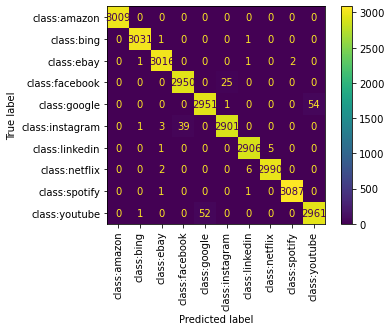

In [12]:
# apply preprocessing to the test set without fitting the estimators
# preprocess the categorical features
x_test_prep_cat = pd.DataFrame(oh_enc.transform(x_test[cat_features]).toarray(), \
                                columns = oh_enc.get_feature_names())          
# remove old categorical features
x_test_sc_only = x_test.drop(cat_features, axis=1)

x_test = pd.DataFrame(ss_enc.transform(x_test_sc_only), columns = x_test_sc_only.columns)\
                        .join(x_test_prep_cat.reset_index(drop=True))

# use the best best_estimatormator from grid search on the test set
t_start = time.time()
y_pred_test = best_estimator.predict(x_test)
pred_time = time.time()- t_start

# metrics
print("Best classifier on test data:\n-global accuracy score -> ", accuracy_score(y_pred_test, y_test),\
      "\nPrediction time -> ", pred_time)
cv_3_avg = cross_val_score(best_estimator, x_test, y_test, scoring='f1_macro', cv=3).mean()
cv_5_avg = cross_val_score(best_estimator, x_test, y_test, scoring='f1_macro', cv=5).mean()
print("Average cross validation score 3-fold: ", cv_3_avg)
print("Average cross validation score 5-fold: ", cv_5_avg)

# confusion matrix
best_cm = confusion_matrix(y_test, y_pred_test, labels=best_estimator.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=best_cm, display_labels=best_estimator.classes_)\
        .plot(xticks_rotation='vertical')

In this case the global accuracy score is misleading, leading us to believe that the predictor works better on the test set. It is not that far off the truth however, seeing as the cross validation score is only slightly lower than what we had for the training set. This indicates that no overfitting occurred and that our grid search paid off. The confusion table is similar to what we had before, with the same Instagram-Facebook indecision and some confusion between the Google-YouTube pair which was not present before.

# Part 2 (optional): Regression Problem

## Task 1: server to client bytes

In [40]:
df = pd.read_csv('log_tcp_complete_classes.txt', sep = " ")

# added new column to drop
to_drop = [
    "#31#c_ip:1", 
    "c_port:2", 
    "s_ip:15", 
    "s_port:16", 
    "c_tls_SNI:116", 
    "s_tls_SCN:117",
    "s_bytes_uniq:21",
    "fqdn:127",
    "class:207"]

df = df.drop(to_drop, axis=1)

cat_features = [
'con_t:42',
'p2p_t:43',
'http_t:44',
'p2p_st:59',
'c_npnalpn:118',
's_npnalpn:119',
'dns_rslv:128',
"http_res:113",
]

#split in training and testing sets
x_train, x_test, y_train, y_test = \
            train_test_split(df.drop('s_bytes_all:23', axis=1), \
                             df['s_bytes_all:23'], \
                             test_size=0.3, random_state=0)

# define preprocessers
oh_enc = OneHotEncoder(handle_unknown='ignore')
ss_enc = StandardScaler()

# preprocess the categorical features
x_train_prep_cat = pd.DataFrame(oh_enc.fit_transform(x_train[cat_features]).toarray(), \
                                columns = oh_enc.get_feature_names())
            
# remove old categorical features
x_train_sc_only = x_train.drop(cat_features, axis=1)

x_train = pd.DataFrame(ss_enc.fit_transform(x_train_sc_only), columns = x_train_sc_only.columns)\
                        .join(x_train_prep_cat.reset_index(drop=True))

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

regressor = DecisionTreeRegressor(max_depth=3)

regressor.fit(x_train, y_train)
# Predict on training set
y_pred_train = regressor.predict(x_train)

# Metrics
mae_bytes_tr = mean_absolute_error(y_train, y_pred_train)
print("The mean absolute errror for the predicted coulumn on training set is ", mae_bytes_tr)


The mean absolute errror for the predicted coulumn on training set is  55096.74774885344


In [41]:
# preprocess test set
# preprocess the categorical features
x_test_prep_cat = pd.DataFrame(oh_enc.transform(x_test[cat_features]).toarray(), \
                                columns = oh_enc.get_feature_names())
            
# remove old categorical features
x_test_sc_only = x_test.drop(cat_features, axis=1)

x_test = pd.DataFrame(ss_enc.transform(x_test_sc_only), columns = x_test_sc_only.columns)\
                        .join(x_test_prep_cat.reset_index(drop=True))

# Predict on test set
y_pred = regressor.predict(x_test)

mae_bytes = mean_absolute_error(y_test, y_pred)
print("The mean absolute errror for the predicted coulumn on test set is ", mae_bytes)


The mean absolute errror for the predicted coulumn on test set is  71673.16169579883


## Task 2: Average Round Trip Time

In [44]:
df = pd.read_csv('log_tcp_complete_classes.txt', sep = " ")

# added new column to drop
to_drop = [
    "#31#c_ip:1", 
    "c_port:2", 
    "s_ip:15", 
    "s_port:16", 
    "c_tls_SNI:116", 
    "s_tls_SCN:117",
    "fqdn:127",
    "class:207",
    "s_rtt_max:54",
    "s_rtt_std:55",
    "c_rtt_avg:45",
    "c_rtt_min:46",
    "c_rtt_max:47",
    "c_rtt_std:48"]

df = df.drop(to_drop, axis=1)

cat_features = [
'con_t:42',
'p2p_t:43',
'http_t:44',
'p2p_st:59',
'c_npnalpn:118',
's_npnalpn:119',
'dns_rslv:128',
"http_res:113",
]

#split in training and testing sets
x_train, x_test, y_train, y_test = \
            train_test_split(df.drop('s_rtt_avg:52', axis=1), \
                             df['s_rtt_avg:52'], \
                             test_size=0.3, random_state=0)

# define preprocessers
oh_enc = OneHotEncoder(handle_unknown='ignore')
ss_enc = StandardScaler()

# preprocess the categorical features
x_train_prep_cat = pd.DataFrame(oh_enc.fit_transform(x_train[cat_features]).toarray(), \
                                columns = oh_enc.get_feature_names())
            
# remove old categorical features
x_train_sc_only = x_train.drop(cat_features, axis=1)

x_train = pd.DataFrame(ss_enc.fit_transform(x_train_sc_only), columns = x_train_sc_only.columns)\
                        .join(x_train_prep_cat.reset_index(drop=True))

regressor = DecisionTreeRegressor(max_depth=3)

regressor.fit(x_train, y_train)
# Predict on training set
y_pred_train = regressor.predict(x_train)

# Metrics
mae_bytes_tr = mean_absolute_error(y_train, y_pred_train)
print("The mean absolute errror for the predicted coulumn on training set is ", mae_bytes_tr)

The mean absolute errror for the predicted coulumn on training set is  32.98712698525928


In [45]:
# preprocess test set
# preprocess the categorical features
x_test_prep_cat = pd.DataFrame(oh_enc.transform(x_test[cat_features]).toarray(), \
                                columns = oh_enc.get_feature_names())
            
# remove old categorical features
x_test_sc_only = x_test.drop(cat_features, axis=1)

x_test = pd.DataFrame(ss_enc.transform(x_test_sc_only), columns = x_test_sc_only.columns)\
                        .join(x_test_prep_cat.reset_index(drop=True))

# Predict on test set
y_pred = regressor.predict(x_test)

mae_bytes = mean_absolute_error(y_test, y_pred)
print("The mean absolute errror for the predicted coulumn on test set is ", mae_bytes)


The mean absolute errror for the predicted coulumn on test set is  32.628553567761614
